In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s6e1/sample_submission.csv
/kaggle/input/playground-series-s6e1/train.csv
/kaggle/input/playground-series-s6e1/test.csv


## Importing Libraries

In [2]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns

## Reading in train dataset

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s6e1/train.csv")
train.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB


## Checking for null values

In [5]:
print("Check Null Columns:")
train.isnull().sum()

Check Null Columns:


id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

## Breaking up columns based on datatype¶

In [6]:
num_col=['age', 'study_hours', 'class_attendance', 'sleep_hours']

category_col=['gender', 'course', 'internet_access', 'sleep_quality', 'study_method',
       'facility_rating', 'exam_difficulty']

target_col = 'exam_score'

## Looping to creating bar graphs (count)

In [7]:
for col in category_col:
    col_count = train[col].value_counts().reset_index()
    col_count.columns = [col, 'Count']

    fig = px.bar(
        col_count,
        x=col,
        y='Count',
        color=col,
        color_discrete_sequence=px.colors.sequential.thermal,
        title=f"{col.replace('_',' ').title()} Distribution",
        text='Count'
    )

    fig.update_layout(width=600, height=400)
    fig.show()

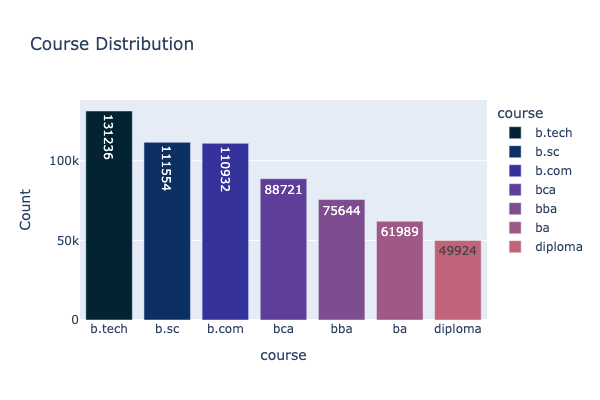

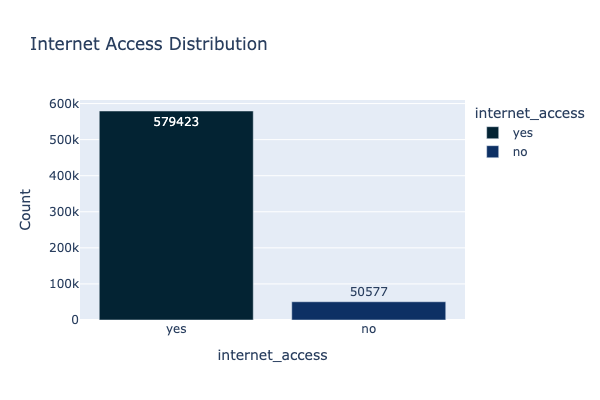

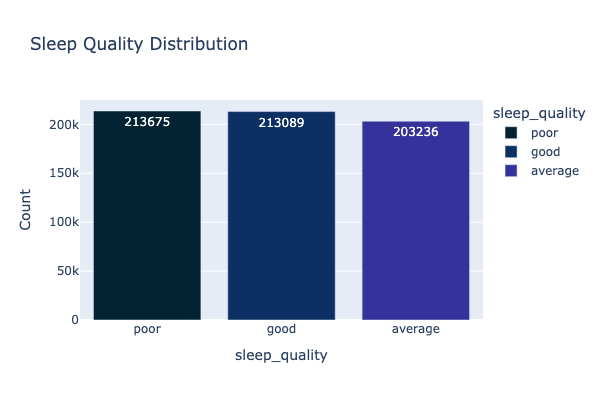

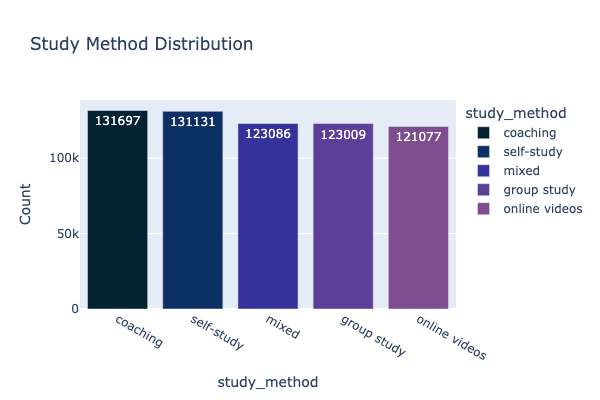

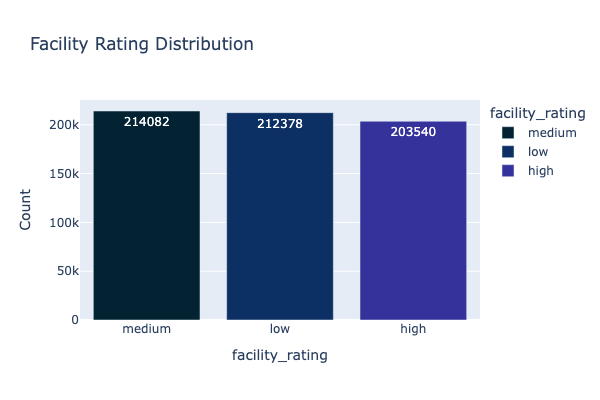

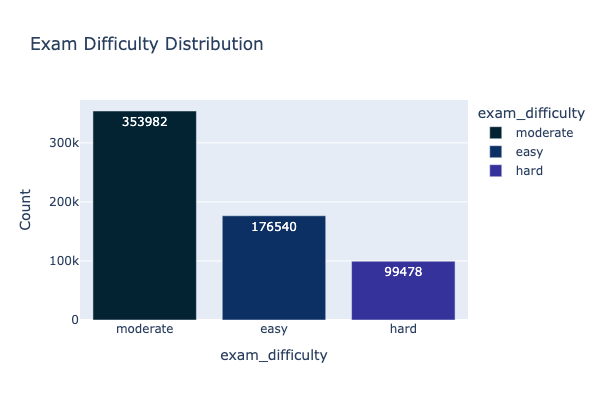

## Residual Plots for Number Columns

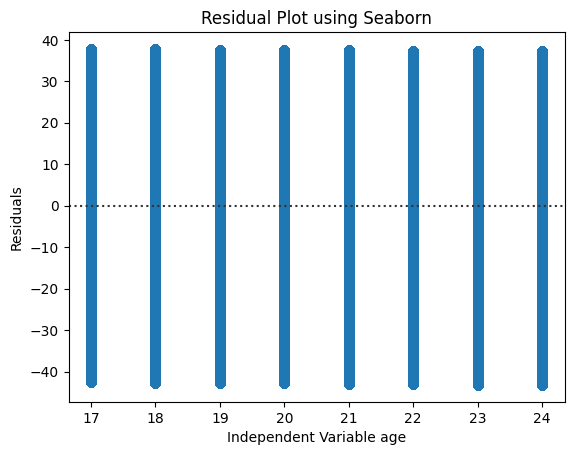

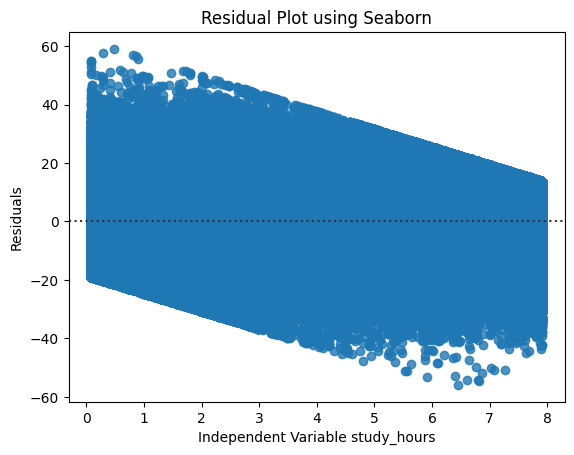

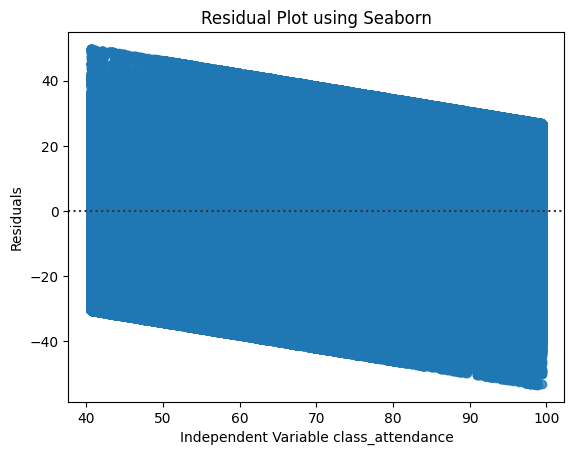

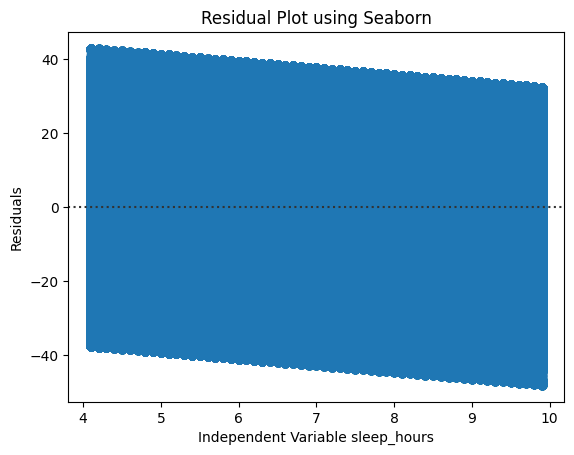

In [8]:
for col in num_col:
    sns.residplot(x=col, y='exam_score', data=train)
    plt.xlabel("Independent Variable " + col)
    plt.ylabel("Residuals")
    plt.title("Residual Plot using Seaborn")
    plt.show()

## Correlation Heatmap of Number Columns

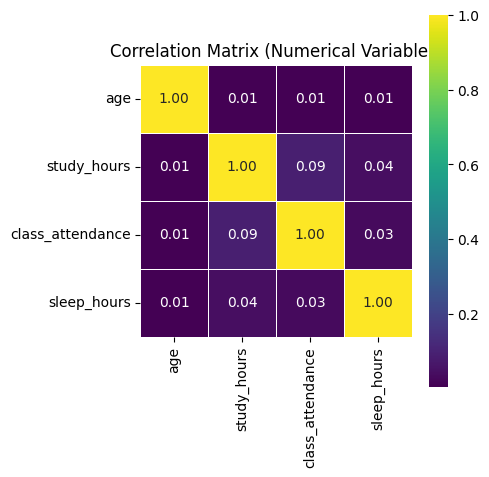

In [9]:
corr_mat = train[num_col].corr()

plt.figure(figsize=(5,5))
sns.heatmap(
    corr_mat,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=0.5,
    square=True
)
plt.title("Correlation Matrix (Numerical Variables)")
plt.tight_layout()
plt.show()

In [10]:
train['sleep_quality'].unique()

array(['average', 'poor', 'good'], dtype=object)

In [11]:
train["sleep_quality"] = train["sleep_quality"].map({"average": 1, "poor": 0, "good": 2})
print(train.head())

   id  age  gender   course  study_hours  class_attendance internet_access  \
0   0   21  female     b.sc         7.91              98.8              no   
1   1   18   other  diploma         4.95              94.8             yes   
2   2   20  female     b.sc         4.68              92.6             yes   
3   3   19    male     b.sc         2.00              49.5             yes   
4   4   23    male      bca         7.65              86.9             yes   

   sleep_hours  sleep_quality   study_method facility_rating exam_difficulty  \
0          4.9              1  online videos             low            easy   
1          4.7              0     self-study          medium        moderate   
2          5.8              0       coaching            high        moderate   
3          8.3              1    group study            high        moderate   
4          9.6              2     self-study            high            easy   

   exam_score  
0        78.3  
1        46.7  
2 

In [12]:
train["exam_difficulty"].unique()

array(['easy', 'moderate', 'hard'], dtype=object)

In [13]:
train["exam_difficulty"] = train["exam_difficulty"].map({"easy": 1, "moderate": 0, "hard": 2})
print(train.head())

   id  age  gender   course  study_hours  class_attendance internet_access  \
0   0   21  female     b.sc         7.91              98.8              no   
1   1   18   other  diploma         4.95              94.8             yes   
2   2   20  female     b.sc         4.68              92.6             yes   
3   3   19    male     b.sc         2.00              49.5             yes   
4   4   23    male      bca         7.65              86.9             yes   

   sleep_hours  sleep_quality   study_method facility_rating  exam_difficulty  \
0          4.9              1  online videos             low                1   
1          4.7              0     self-study          medium                0   
2          5.8              0       coaching            high                0   
3          8.3              1    group study            high                0   
4          9.6              2     self-study            high                1   

   exam_score  
0        78.3  
1        46.

In [14]:
# 'gender', 'course', 'internet_access'
train["gender"].unique()
train["gender"] = train["gender"].map({"female": 1, "other": 0, "male": 2})


In [15]:
train["course"].unique()
train["course"] = train["course"].map({"b.sc": 1, "diploma": 0, "bca": 2, "b.com":3,"ba":4, "bba":5,"b.tech":6 })

In [16]:
train["internet_access"].unique()
train["internet_access"] = train["internet_access"].map({"no": 1, "yes": 0})

In [17]:
# study_method','facility_rating',
train["study_method"].unique()
train["study_method"] = train["study_method"].map({"online videos": 1, "self-study": 0, "coaching":2,"group study":3,"mixed":4  })


In [18]:
train["facility_rating"].unique()
train["facility_rating"] = train["facility_rating"].map({"low": 1, "medium": 0, "high":2})
train.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,1,1,7.91,98.8,1,4.9,1,1,1,1,78.3
1,1,18,0,0,4.95,94.8,0,4.7,0,0,0,0,46.7
2,2,20,1,1,4.68,92.6,0,5.8,0,2,2,0,99.0
3,3,19,2,1,2.00,49.5,0,8.3,1,3,2,0,63.9
4,4,23,2,2,7.65,86.9,0,9.6,2,0,2,1,100.0


## Correlation Heatmap of Non Numerical Variables

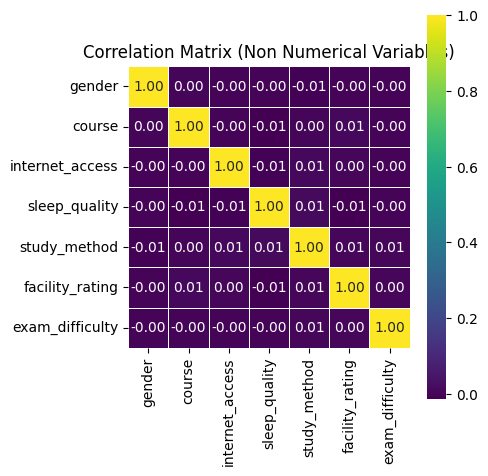

In [19]:
corr_mat = train[category_col].corr()

plt.figure(figsize=(5,5))
sns.heatmap(
    corr_mat,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=0.5,
    square=True
)
plt.title("Correlation Matrix (Non Numerical Variables)")
plt.tight_layout()
plt.show()

## Correlation Heatmap of All Variables

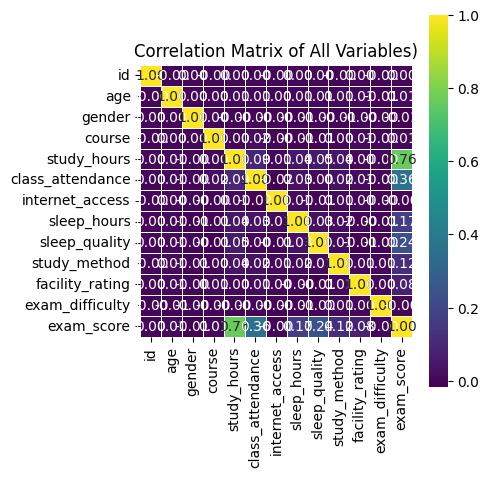

In [20]:
corr_mat = train.corr()

plt.figure(figsize=(5,5))
sns.heatmap(
    corr_mat,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=0.5,
    square=True
)
plt.title("Correlation Matrix of All Variables)")
plt.tight_layout()
plt.show()

## Labeling x and y for training

In [21]:
X=train[num_col + category_col]
y=train["exam_score"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [24]:
y_pred = model.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R²: 0.7335217537804068
MAE: 7.804168030933367
RMSE: 9.735102993861771


## Reading in test data

In [25]:
test=pd.read_csv("/kaggle/input/playground-series-s6e1/test.csv")
print(test.head())

       id  age  gender   course  study_hours  class_attendance  \
0  630000   24   other       ba         6.85              65.2   
1  630001   18    male  diploma         6.61              45.0   
2  630002   24  female   b.tech         6.60              98.5   
3  630003   24    male  diploma         3.03              66.3   
4  630004   20  female   b.tech         2.03              42.4   

  internet_access  sleep_hours sleep_quality study_method facility_rating  \
0             yes          5.2          poor  group study            high   
1              no          9.3          poor     coaching             low   
2             yes          6.2          good  group study          medium   
3             yes          5.7       average        mixed          medium   
4             yes          9.2       average     coaching             low   

  exam_difficulty  
0            easy  
1            easy  
2        moderate  
3        moderate  
4        moderate  


In [26]:
test["sleep_quality"] = test["sleep_quality"].map({"average": 1, "poor": 0, "good": 2})
print(test["sleep_quality"])

0         0
1         0
2         2
3         1
4         1
         ..
269995    1
269996    2
269997    2
269998    0
269999    0
Name: sleep_quality, Length: 270000, dtype: int64


In [27]:
test["exam_difficulty"] = test["exam_difficulty"].map({"easy": 1, "moderate": 0, "hard": 2})
print(test.head())

       id  age  gender   course  study_hours  class_attendance  \
0  630000   24   other       ba         6.85              65.2   
1  630001   18    male  diploma         6.61              45.0   
2  630002   24  female   b.tech         6.60              98.5   
3  630003   24    male  diploma         3.03              66.3   
4  630004   20  female   b.tech         2.03              42.4   

  internet_access  sleep_hours  sleep_quality study_method facility_rating  \
0             yes          5.2              0  group study            high   
1              no          9.3              0     coaching             low   
2             yes          6.2              2  group study          medium   
3             yes          5.7              1        mixed          medium   
4             yes          9.2              1     coaching             low   

   exam_difficulty  
0                1  
1                1  
2                0  
3                0  
4                0  


In [28]:
test["gender"] = test["gender"].map({"female": 1, "other": 0, "male": 2})
test["course"] = test["course"].map({"b.sc": 1, "diploma": 0, "bca": 2, "b.com":3,"ba":4, "bba":5,"b.tech":6 })
test["internet_access"] = test["internet_access"].map({"no": 1, "yes": 0})
test["study_method"] = test["study_method"].map({"online videos": 1, "self-study": 0, "coaching":2,"group study":3,"mixed":4  })
test["facility_rating"] = test["facility_rating"].map({"low": 1, "medium": 0, "high":2})

In [29]:
X_test2= test[num_col + category_col]

In [30]:
exam_score_predictions = model.predict(X_test2)
print(exam_score_predictions)

[72.77643289 67.29017965 88.65595442 ... 82.48008792 55.10430557
 67.69667269]


In [31]:
y_pred = model.predict(X_test2)

#print("R²:", r2_score(y_test, y_pred))
#print("MAE:", mean_absolute_error(y_test, y_pred))
#print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

## Creating Output

In [32]:
output = pd.DataFrame({
    "id": test["id"],
    "exam_score": exam_score_predictions
})

output.to_csv("predictions.csv", index=False)